In [31]:
import pandas as pd
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt

import cv2
import os
from random import shuffle
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split

from PIL import Image

from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Model, layers

import itertools
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [3]:
B_DIR = "./data/basal-cell-carcinoma/train/"
M_DIR =  "./data/melanoma/train/"
N_DIR = "./data/nevus/train/"

Bimages = os.listdir(B_DIR)
Mimages = os.listdir(M_DIR)
Nimages = os.listdir(N_DIR)

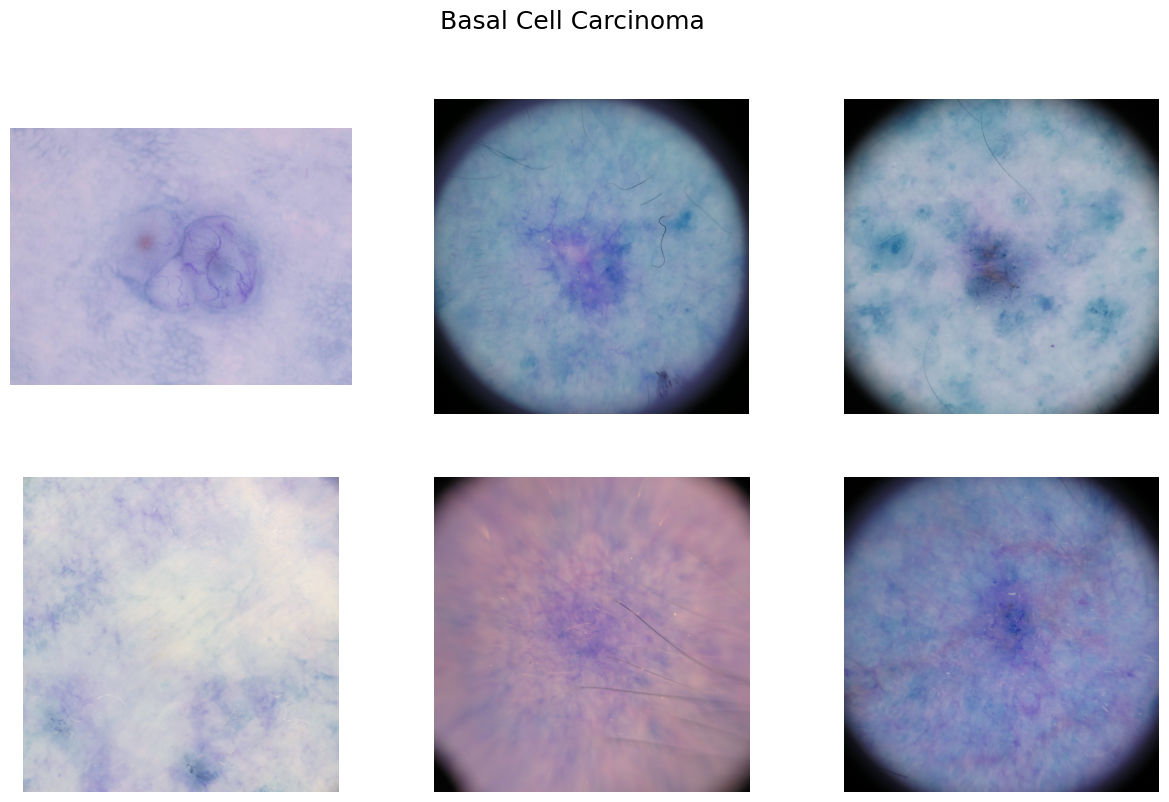

In [4]:
sample = random.sample(Bimages, 6)
fig, ax = plt.subplots(2, 3, figsize=(15, 9))

for i in range(6):
  img = cv2.imread(B_DIR + sample[i])
  ax[i//3, i%3].imshow(img)
  ax[i//3, i%3].axis('off')
fig.suptitle('Basal Cell Carcinoma', fontsize=18)
plt.show()

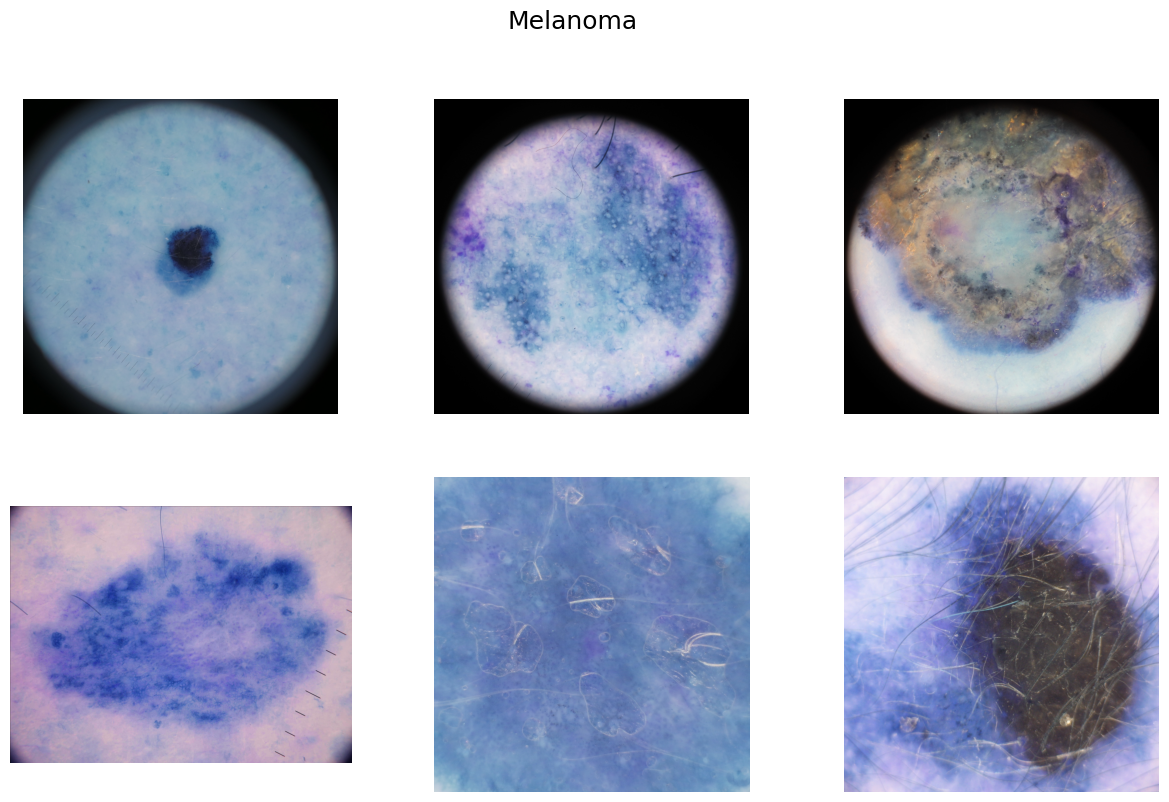

In [5]:
sample = random.sample(Mimages, 6)
fig, ax = plt.subplots(2, 3, figsize=(15, 9))

for i in range(6):
  img = cv2.imread(M_DIR + sample[i])
  ax[i//3, i%3].imshow(img)
  ax[i//3, i%3].axis('off')
fig.suptitle('Melanoma', fontsize=18)
plt.show()

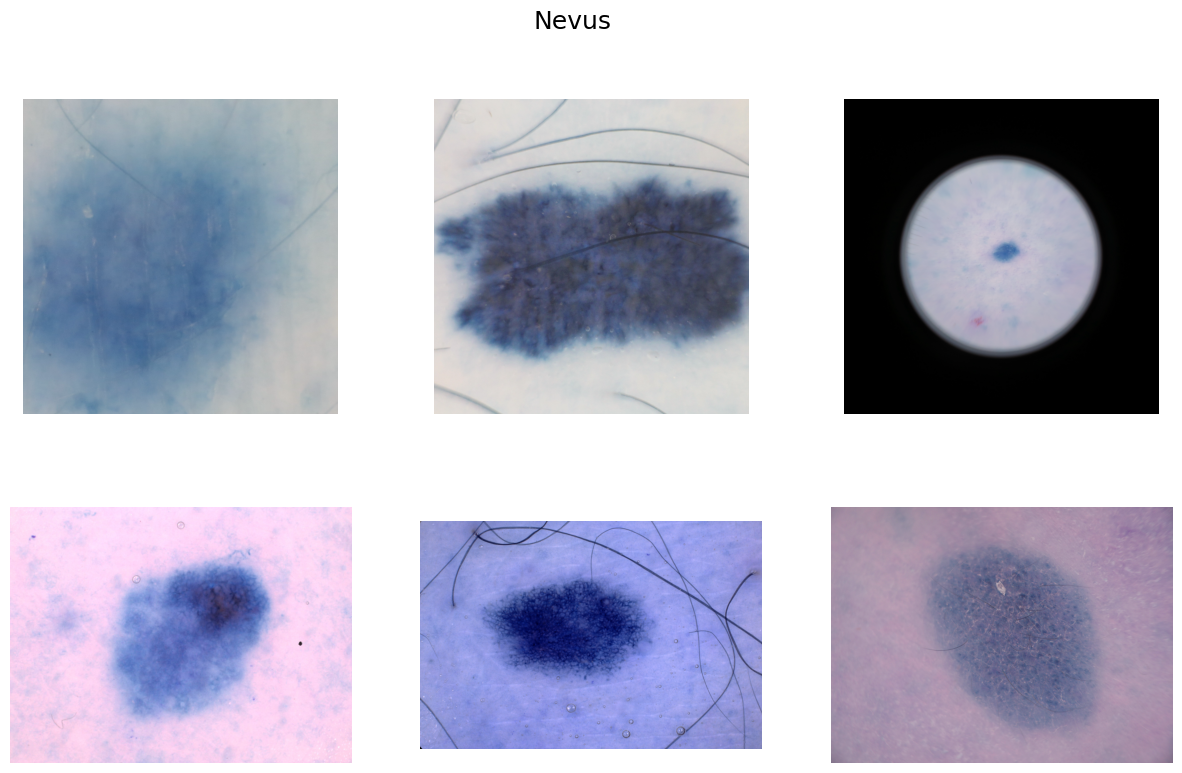

In [6]:
sample = random.sample(Nimages, 6)
fig, ax = plt.subplots(2, 3, figsize=(15, 9))

for i in range(6):
  img = cv2.imread(N_DIR + sample[i])
  ax[i//3, i%3].imshow(img)
  ax[i//3, i%3].axis('off')
fig.suptitle('Nevus', fontsize=18)
plt.show()

In [7]:
data = []
labels = []
for image in Bimages:
  try:
    img = cv2.imread(B_DIR + image)
    img_array = Image.fromarray(img, 'RGB')
    img_size = img_array.resize((224, 224))
    data.append(np.array(img_size))
    labels.append(0)
  except AttributeError:
    pass

for image in Mimages:
  try:
    img = cv2.imread(M_DIR + image)
    img_array = Image.fromarray(img, 'RGB')
    img_size = img_array.resize((224, 224))
    data.append(np.array(img_size))
    labels.append(1)
  except AttributeError:
    pass

for image in Nimages:
  try:
    img = cv2.imread(N_DIR + image)
    img_array = Image.fromarray(img, 'RGB')
    img_size = img_array.resize((224, 224))
    data.append(np.array(img_size))
    labels.append(2)
  except AttributeError:
    pass

In [8]:
print(len(data))
print(len(labels))

20720
20720


In [9]:
FEATURES_DIR = './features-train'
LABELS_DIR = './labels-train'

features = np.array(data)
labels = np.array(labels)

np.save(FEATURES_DIR, features)
np.save(LABELS_DIR, labels)

In [4]:
features = np.load('./features-train.npy')
labels = np.load('./labels-train.npy')

In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    features, labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

In [6]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
train_len=len(x_train)
test_len=len(x_test)

In [7]:
y_train=to_categorical(y_train,3)
y_test=to_categorical(y_test,3)

In [8]:
trainAug  = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

In [11]:
conv_base = MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = True

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 38s 4us/step


In [12]:
def build_model(conv_base):
    x = conv_base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    predictions = layers.Dense(3, activation='softmax')(x)
    
    return Model(conv_base.input, predictions)

model = build_model(conv_base)

In [13]:
callbacks = [ModelCheckpoint('.mdl_wts.hdf5.keras', monitor='val_loss',mode='min',verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)]

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
batch_size = 64
print("[INFO] training head...")
H = model.fit(
	trainAug.flow(x_train,y_train, batch_size=batch_size),
	steps_per_epoch=train_len // batch_size,
	validation_data=(x_test, y_test),
	validation_steps=test_len // batch_size,
	epochs=30,
    callbacks=callbacks
)

[INFO] training head...
Epoch 1/30


I0000 00:00:1762970879.948851   68276 service.cc:152] XLA service 0x76f928016a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762970879.948870   68276 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-11-12 21:38:00.270175: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762970881.653158   68276 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-11-12 21:38:03.738414: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8058', 468 bytes spill stores, 468 bytes spill loads

2025-11-12 21:38:03.814789: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fus

259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7562 - loss: 0.6009

2025-11-12 21:41:23.661995: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1204', 4 bytes spill stores, 4 bytes spill loads

2025-11-12 21:41:23.701298: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1197', 4 bytes spill stores, 4 bytes spill loads

2025-11-12 21:41:24.057689: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1197_0', 108 bytes spill stores, 108 bytes spill loads

2025-11-12 21:41:24.127155: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1204', 156 bytes spill stores, 156 bytes spill loads

2025-11-12 21:41:24.290154: I external


Epoch 1: val_loss improved from None to 6.36534, saving model to .mdl_wts.hdf5.keras
259/259 ━━━━━━━━━━━━━━━━━━━━ 248s 749ms/step - accuracy: 0.7813 - loss: 0.5428 - val_accuracy: 0.6233 - val_loss: 6.3653 - learning_rate: 0.0010
Epoch 2/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8131 - loss: 0.4590
Epoch 2: val_loss did not improve from 6.36534
259/259 ━━━━━━━━━━━━━━━━━━━━ 116s 448ms/step - accuracy: 0.8163 - loss: 0.4553 - val_accuracy: 0.6375 - val_loss: 7.2434 - learning_rate: 0.0010
Epoch 3/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8444 - loss: 0.3934
Epoch 3: val_loss did not improve from 6.36534

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
259/259 ━━━━━━━━━━━━━━━━━━━━ 115s 443ms/step - accuracy: 0.8371 - loss: 0.4082 - val_accuracy: 0.6513 - val_loss: 6.9370 - learning_rate: 0.0010
Epoch 4/30
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.8721 - loss: 0.3233
Epoch 4: val_loss improved from 6.36534 to 5

In [16]:
model = load_model('.mdl_wts.hdf5.keras')
model.save('./model_v1.h5.keras')

In [9]:
model = load_model('./model_v1.h5.keras')
accuracy = model.evaluate(x_test, y_test, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

I0000 00:00:1763009622.745308    6001 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6153 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1763009633.309801    8130 service.cc:152] XLA service 0x7a183c014230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763009633.309898    8130 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-11-13 08:23:53.366496: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763009633.604874    8130 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-11-13 08:23:54.388075: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm

129/130 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8875 - loss: 0.5155

2025-11-13 08:24:10.021832: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1197', 4 bytes spill stores, 4 bytes spill loads

2025-11-13 08:24:10.342033: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1197_0', 200 bytes spill stores, 536 bytes spill loads

2025-11-13 08:24:10.359778: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1197', 116 bytes spill stores, 116 bytes spill loads

2025-11-13 08:24:10.673686: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1197', 5616 bytes spill stores, 5612 bytes spill loads

2025-11-13 08:24:10.790324: I ex

130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 107ms/step - accuracy: 0.8948 - loss: 0.4807

 Test_Accuracy:- 0.8947876691818237


In [10]:
rounded_predictions = model.predict(x_test, batch_size=16, verbose=0)
rounded_predictions[1]

array([7.3937792e-04, 2.2903360e-01, 7.7022696e-01], dtype=float32)

259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step


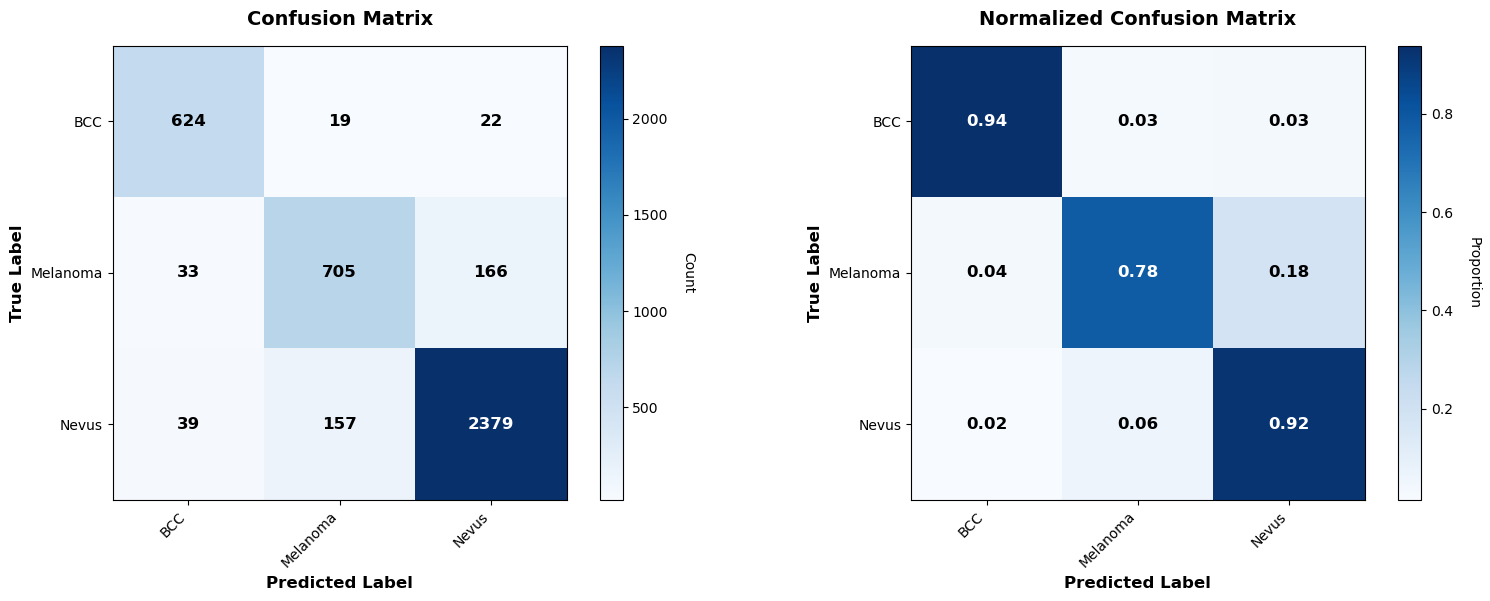


Confusion Matrix:
[[ 624   19   22]
 [  33  705  166]
 [  39  157 2379]]


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

# Configuration
BATCH_SIZE = 16
CLASS_NAMES = ['BCC', 'Melanoma', 'Nevus']

# Get predictions
y_pred_probs = model.predict(x_test, batch_size=BATCH_SIZE, verbose=True)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot both confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (normalize, title) in enumerate([(False, 'Confusion Matrix'), 
                                           (True, 'Normalized Confusion Matrix')]):
    ax = axes[idx]
    
    # Normalize if needed
    cm_plot = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] if normalize else cm
    fmt = '.2f' if normalize else 'd'
    
    # Create heatmap
    im = ax.imshow(cm_plot, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Proportion' if normalize else 'Count', rotation=270, labelpad=20)
    
    # Set ticks and labels
    tick_marks = np.arange(len(CLASS_NAMES))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(CLASS_NAMES, rotation=45, ha='right')
    ax.set_yticklabels(CLASS_NAMES)
    
    # Add text annotations
    thresh = cm_plot.max() / 2.
    for i, j in itertools.product(range(cm_plot.shape[0]), range(cm_plot.shape[1])):
        ax.text(j, i, format(cm_plot[i, j], fmt),
               horizontalalignment="center",
               verticalalignment="center",
               color="white" if cm_plot[i, j] > thresh else "black",
               fontsize=12, fontweight='bold')
    
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print confusion matrix
print("\nConfusion Matrix:")
print(cm)


In [12]:
BATCH_SIZE = 16
CLASS_NAMES = ['BCC', 'Melanoma', 'Nevus']

y_pred_classes = np.argmax(model.predict(x_test, batch_size=BATCH_SIZE), axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes, 
                           target_names=CLASS_NAMES, digits=4))

259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
              precision    recall  f1-score   support

         BCC     0.8966    0.9383    0.9170       665
    Melanoma     0.8002    0.7799    0.7899       904
       Nevus     0.9268    0.9239    0.9253      2575

    accuracy                         0.8948      4144
   macro avg     0.8745    0.8807    0.8774      4144
weighted avg     0.8943    0.8948    0.8944      4144



259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step


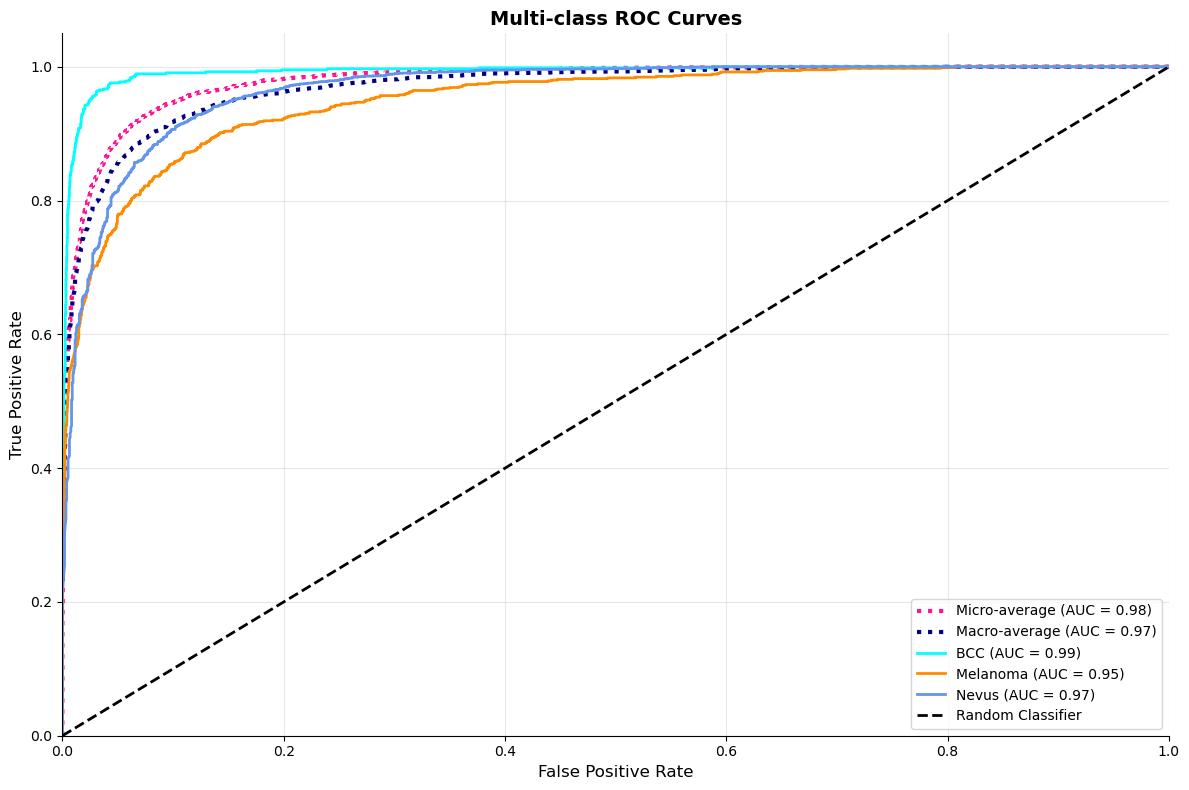

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Configuration
BATCH_SIZE = 16
CLASS_NAMES = ['BCC', 'Melanoma', 'Nevus']
N_CLASSES = len(CLASS_NAMES)

# Get predictions
y_pred_probs = model.predict(x_test, batch_size=BATCH_SIZE, verbose=True)
y_test = np.array(y_test)

# Compute ROC curves
fpr, tpr, roc_auc = {}, {}, {}

for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(N_CLASSES)]))
mean_tpr = np.mean([np.interp(all_fpr, fpr[i], tpr[i]) for i in range(N_CLASSES)], axis=0)
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all curves
plt.figure(figsize=(12, 8))

# Averages
plt.plot(fpr["micro"], tpr["micro"], 'deeppink', linestyle=':', linewidth=3,
         label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')
plt.plot(fpr["macro"], tpr["macro"], 'navy', linestyle=':', linewidth=3,
         label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})')

# Individual classes
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, (color, name) in enumerate(zip(colors, CLASS_NAMES)):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC Curves', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()


In [17]:
B_DIR_TEST = "./data/basal-cell-carcinoma/test/"
M_DIR_TEST =  "./data/melanoma/test/"
N_DIR_TEST = "./data/nevus/test/"

Bimages_test = os.listdir(B_DIR_TEST)
Mimages_test = os.listdir(M_DIR_TEST)
Nimages_test = os.listdir(N_DIR_TEST)

In [ ]:
data = []
labels = []
for image in Bimages_test:
  try:
    img = cv2.imread(B_DIR_TEST + image)
    img_array = Image.fromarray(img, 'RGB')
    img_size = img_array.resize((224, 224))
    data.append(np.array(img_size))
    labels.append(0)
  except AttributeError:
    pass

for image in Mimages_test:
  try:
    img = cv2.imread(M_DIR_TEST + image)
    img_array = Image.fromarray(img, 'RGB')
    img_size = img_array.resize((224, 224))
    data.append(np.array(img_size))
    labels.append(1)
  except AttributeError:
    pass

for image in Nimages_test:
  try:
    img = cv2.imread(N_DIR_TEST + image)
    img_array = Image.fromarray(img, 'RGB')
    img_size = img_array.resize((224, 224))
    data.append(np.array(img_size))
    labels.append(2)
  except AttributeError:
    pass

In [19]:
print(len(data), len(labels))

150 150


In [20]:
FEATURES_TEST_DIR = './features-test'
LABELS_TEST_DIR = './labels-test'

features_test = np.array(data)
labels_test = np.array(labels)

np.save(FEATURES_TEST_DIR, features_test)
np.save(LABELS_TEST_DIR, labels_test)

In [21]:
features_test = np.load('./features-test.npy')
labels_test = np.load('./labels-test.npy')

In [22]:
x_valid = features_test.astype('float32')/255
y_valid=to_categorical(labels_test,3)

 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

2025-11-13 08:52:27.826318: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1152', 12 bytes spill stores, 12 bytes spill loads

2025-11-13 08:52:28.066446: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1152_0', 176 bytes spill stores, 524 bytes spill loads

2025-11-13 08:52:28.135695: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1152', 104 bytes spill stores, 104 bytes spill loads

2025-11-13 08:52:28.421333: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1152', 4760 bytes spill stores, 4760 bytes spill loads

2025-11-13 08:52:28.517953: I 

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step 


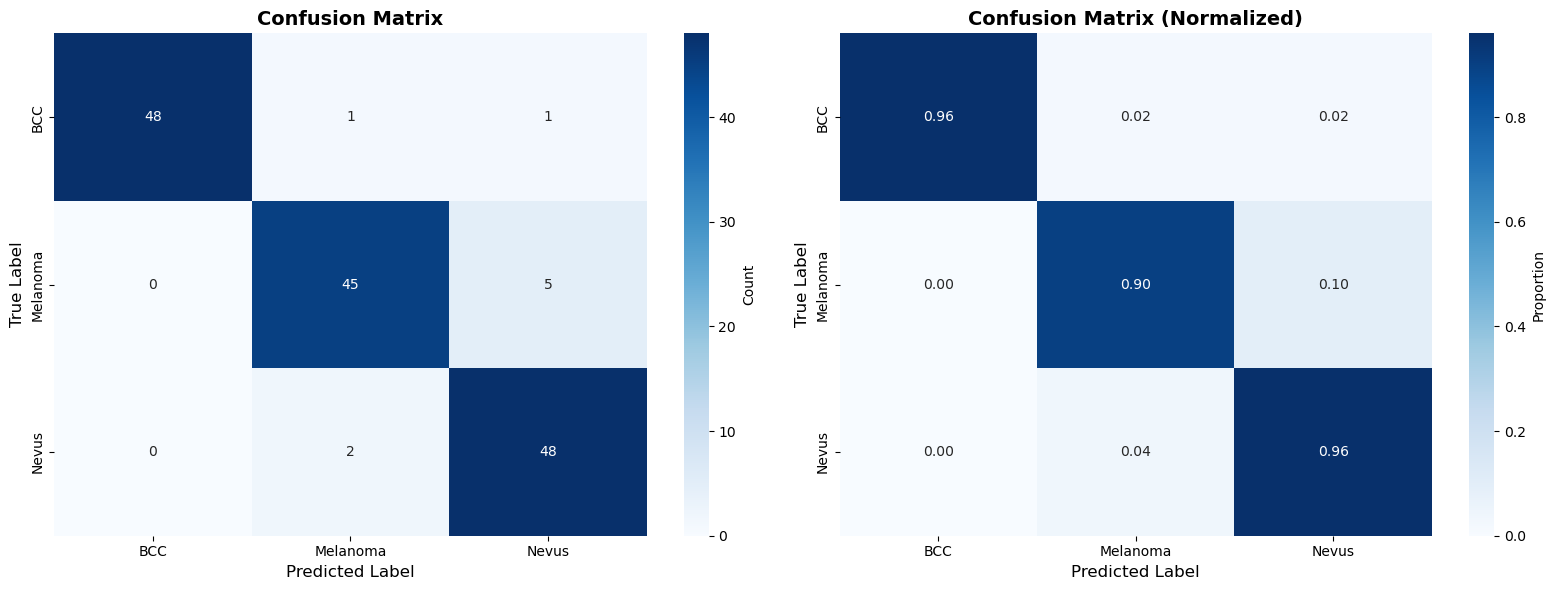


Confusion Matrix:
[[48  1  1]
 [ 0 45  5]
 [ 0  2 48]]


In [23]:
# Configuration
BATCH_SIZE = 16
CLASS_NAMES = ['BCC', 'Melanoma', 'Nevus']

# Get predictions
y_pred_probs = model.predict(x_valid, batch_size=BATCH_SIZE, verbose=True)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_valid, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Normalized
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=axes[1], cbar_kws={'label': 'Proportion'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
print(cm)


In [25]:
model = load_model('./model_v1.h5.keras')

In [26]:
img1 = "./data/nevus/test/nevus_ISIC_0000317.jpg"
img2 ="./data/melanoma/test/melanoma_ISIC_0010175.jpg"
img3 = "./data/basal-cell-carcinoma/test/bcc_ISIC_0033666.jpg"

class_dict ={0:"Basal-Cell-Carcinoma (Cancer)",
             1:"Melanoma (Cancer)",
             2:"Nevus (Non-Cancerous)"}

In [46]:
def pred_image(img_path,model):
  img = Image.open(img_path).resize((224,224))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = img.astype('float32')/255
  
  preds = model.predict(img)
  pred = np.argmax(preds,axis = 1)
  pred_cat = class_dict[pred[0]]

  
  return pred_cat


In [47]:
pred_image(img1,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


'Nevus (Non-Cancerous)'

In [42]:
pred_image(img2,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


'Melanoma (Cancer)'

In [43]:
pred_image(img3,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


'Basal-Cell-Carcinoma (Cancer)'

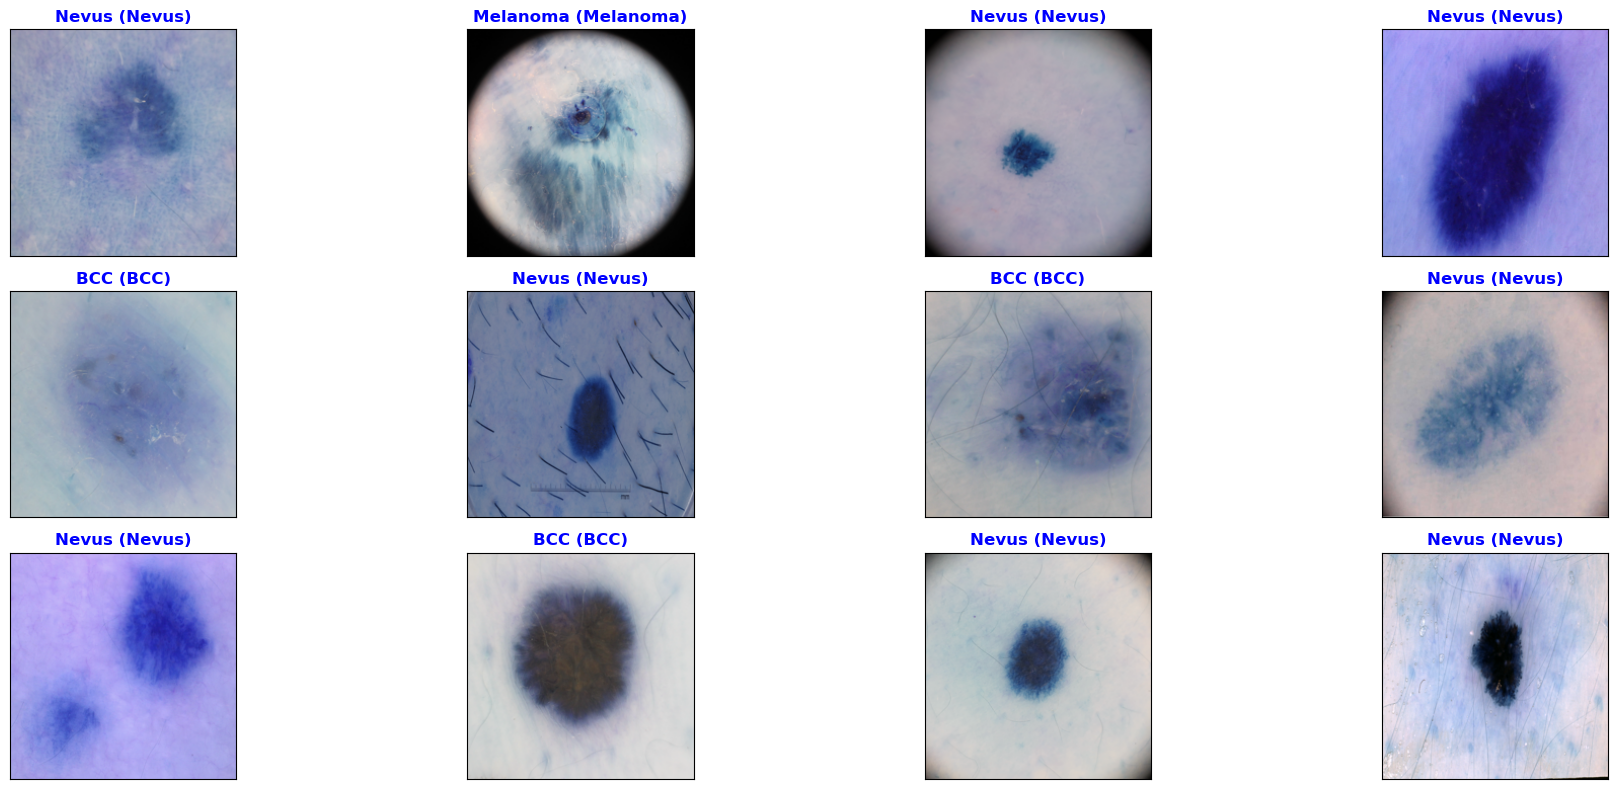

In [48]:
skin_labels = ['BCC', 'Melanoma', 'Nevus']

y_hat = model.predict(x_test, verbose=0)

n_samples = 12
random_indices = np.random.choice(x_test.shape[0], size=n_samples, replace=False)

fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(random_indices):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    
    is_correct = pred_idx == true_idx
    title_color = "blue" if is_correct else "orange"
    
    ax.set_title(f"{skin_labels[pred_idx]} ({skin_labels[true_idx]})",
                 color=title_color, fontweight='bold')

plt.tight_layout()
plt.show()
